In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
%matplotlib inline
seed = 42
np.random.seed(seed)

In [14]:
epoches = [5, 10, 20, 50]
batches = [64, 128, 256]
optimrs = ['rmsprop', 'adam']

In [15]:
hps = dict(optimizer = optimrs, epochs = epoches, batch_size = batches)

In [16]:
(x_ftrain, y_ftrain), (x_ftest, y_ftest) = mnist.load_data()

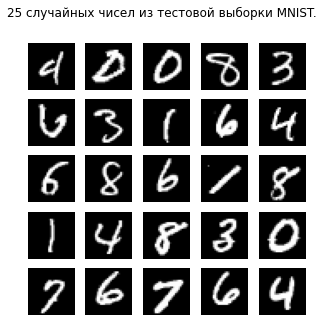

In [17]:
indexes = np.random.randint(0, x_ftrain.shape[0], size = 25)
images = x_ftrain[indexes]
labels = y_ftrain[indexes]
fig_mnist = plt.figure(figsize=(5, 5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i+1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
fig_mnist.suptitle("25 случайных чисел из тестовой выборки MNIST.")
plt.show()

In [18]:
x_ftrain = np.reshape(x_ftrain, [-1, 784]).astype("float32")/255
x_ftest = np.reshape(x_ftest, [-1, 784]).astype("float32")/255
y_ftrain_binary = to_categorical(y_ftrain)
y_ftest_binary = to_categorical(y_ftest)
display(x_ftrain.shape)
display(x_ftest.shape)
display(y_ftrain_binary.shape)
display(y_ftest_binary.shape)

(60000, 784)

(10000, 784)

(60000, 10)

(10000, 10)

In [19]:
def mnist_model(optimizer = 'adam'):
  model = Sequential()
  model.add(Dense(256, input_dim = 784)) #Ввод всех 784 чёрно-белых (0-255) пикселей с изображения.
  model.add(Activation('relu'))
  model.add(Dropout(0.45))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dropout(0.45))
  model.add(Dense(10)) #10 возможных цифр.
  model.add(Activation('softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [20]:
mnist_estimator = KerasClassifier(model = mnist_model, verbose = 1)

In [21]:
mnist_grid = GridSearchCV(estimator = mnist_estimator, param_grid = hps, verbose = 1)

In [22]:
mnist_grid_result = mnist_grid.fit(x_ftrain, y_ftrain_binary, verbose = 0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
47/47 [==============================] - 0s 4ms/step


In [23]:
print("Лучшие параметры:", mnist_grid_result.best_params_)
print("Лучшая точность:", mnist_grid_result.best_score_)

Лучшие параметры: {'batch_size': 128, 'epochs': 50, 'optimizer': 'rmsprop'}
Лучшая точность: 0.9810166666666665


In [28]:
mnist_estimator = KerasClassifier(model = mnist_model, epochs = mnist_grid_result.best_params_['epochs'], batch_size = mnist_grid_result.best_params_['batch_size'], optimizer = mnist_grid_result.best_params_['optimizer'], verbose = 0)
mnist_kfold = KFold(n_splits = 10, shuffle = True, random_state = seed)
results = cross_val_score(mnist_estimator, x_ftrain, y_ftrain_binary, cv = mnist_kfold)
print("Средняя точность: "+str(results.mean()*100)+" %.")
print("Отклонение: "+str(results.std()*100)+" %.")

Средняя точность: 98.19166666666668 %.
Отклонение: 0.15798206649279267 %.
